# Final Project
## Classification and Visualization on Damaged Houses with Different CNN

## Video Link
https://drive.google.com/file/d/1lNpkEbqn3PaMVhZjdfat_32tQ5mczoZG/view?usp=sharing

## Poster Link
https://drive.google.com/file/d/1eH2br1O2J_JKZwd5CuWQWpECC4dX-yra/view?usp=sharing

## Group Member
Haoze Wu, Liuding He, Shuyi Pi

## Overview

In this notebook, two CNN structures are compared over the Satellte Image Dataset.
We are willing to show some performace difference between VGG19 network and ResNet18 network. Since the numbers of Convolution layers are almost the same within these two networks, comparison between those two networks seems to be considerable.
The structure of this notebook is described followed:
* View some samples of Datasets
* Dataset loading and preprsessing
* VGG19 network building and training
* ResNet18 network building and training
* Results comparision and conclusion

## Preparation

Before staring dealing with data, first import some essential libraries, the use of them are described followed:
* `numpy`: Basic math support
* `tensorflow`: NN library, our models are built based on it
* `matplolib`: View samples and data
* `glob`: Walking the files and folders to gain data
* `cv2`: OpenCV library, used for data preprocessing
* `pillow`: Used to load single piece of images
* `random`: Used to generate random array indexes

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib import pyplot as plt
from glob import glob
import cv2
from PIL import Image
import random

## View some samples

First, define the working data path, used for dataset loading and preprocessing.

In [4]:
dataset_path='../input/satellite-images-of-hurricane-damage/'
# dataset_path='archive/'

Using Matplotlib to view three chosen samples from training set and test set.

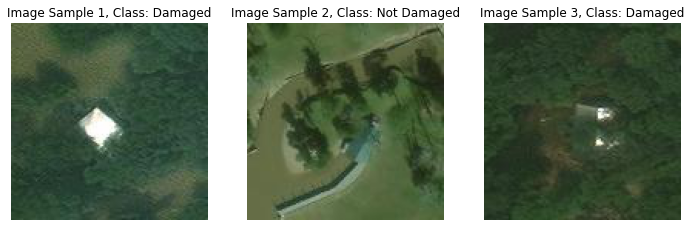

In [5]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
image_sample1=plt.imread(dataset_path+'train_another/damage/-93.55964_30.895018.jpeg')
image_sample2=plt.imread(dataset_path+'train_another/no_damage/-95.061275_29.831535.jpeg')
image_sample3=plt.imread(dataset_path+'test_another/damage/-93.528502_30.987438.jpeg')
ax[0].imshow(image_sample1)
ax[0].set_title('Image Sample 1, Class: Damaged')
ax[0].axis('off')
ax[1].imshow(image_sample2)
ax[1].axis('off')
ax[1].set_title('Image Sample 2, Class: Not Damaged')
ax[2].imshow(image_sample3)
ax[2].axis('off')
ax[2].set_title('Image Sample 3, Class: Damaged')
plt.show()

**Discoveries**:

From samples above and other pictures we found that damaged houses are always surrounded by water and some of those damaged house are not intact in shape. Later we will examine whether CNN models could make determination like humans do.

## Load datasets and preprocessing

We first define a function that could help us do Gaussian Blur using OpenCV-Python library. 
This function would be used in data preprocessing by adding it to ImageDataGenerator's `preprocessing_function` arg.

The reason why we apply Gaussian Blur here is that the original Image is of low resolution and too much noise is included in the image. Gaussian Blur could remove some of noise here.

In [6]:
def gaussian_preprocess(image):
    return cv2.GaussianBlur(image,(5,5),0)

Also, we define two ImageDataGenerators for Training set and Validation set respectively.
In those ImageDataGenerators, we do mutiple transformations, including flipping, zooming, shifting, normalization, and so on.
And the way we apply those generators to original data is by calling `flow_from_dicectory`, directly flowing data from folders to generators.

In [7]:
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=gaussian_preprocess,
)

train_data=train_gen.flow_from_directory(dataset_path+'train_another',batch_size=8,class_mode='binary',shuffle = True,target_size=(128,128))

vali_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, 
        rescale=1./255,
        width_shift_range=0.15, 
        height_shift_range=0.15, 
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=gaussian_preprocess,
)

vali_data=vali_gen.flow_from_directory(dataset_path+'test',batch_size=8,class_mode='binary',shuffle = True,target_size=(128,128))

test_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data=test_gen.flow_from_directory(dataset_path+'test',batch_size=8,class_mode='binary',shuffle = True,target_size=(128,128))

another_test_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
another_test_data=another_test_gen.flow_from_directory(dataset_path+'test_another',batch_size=8,class_mode='binary',shuffle = True,target_size=(128,128))


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


View some features of generators and some preprocessed samples as well.

In [8]:
train_data.class_indices

{'damage': 0, 'no_damage': 1}

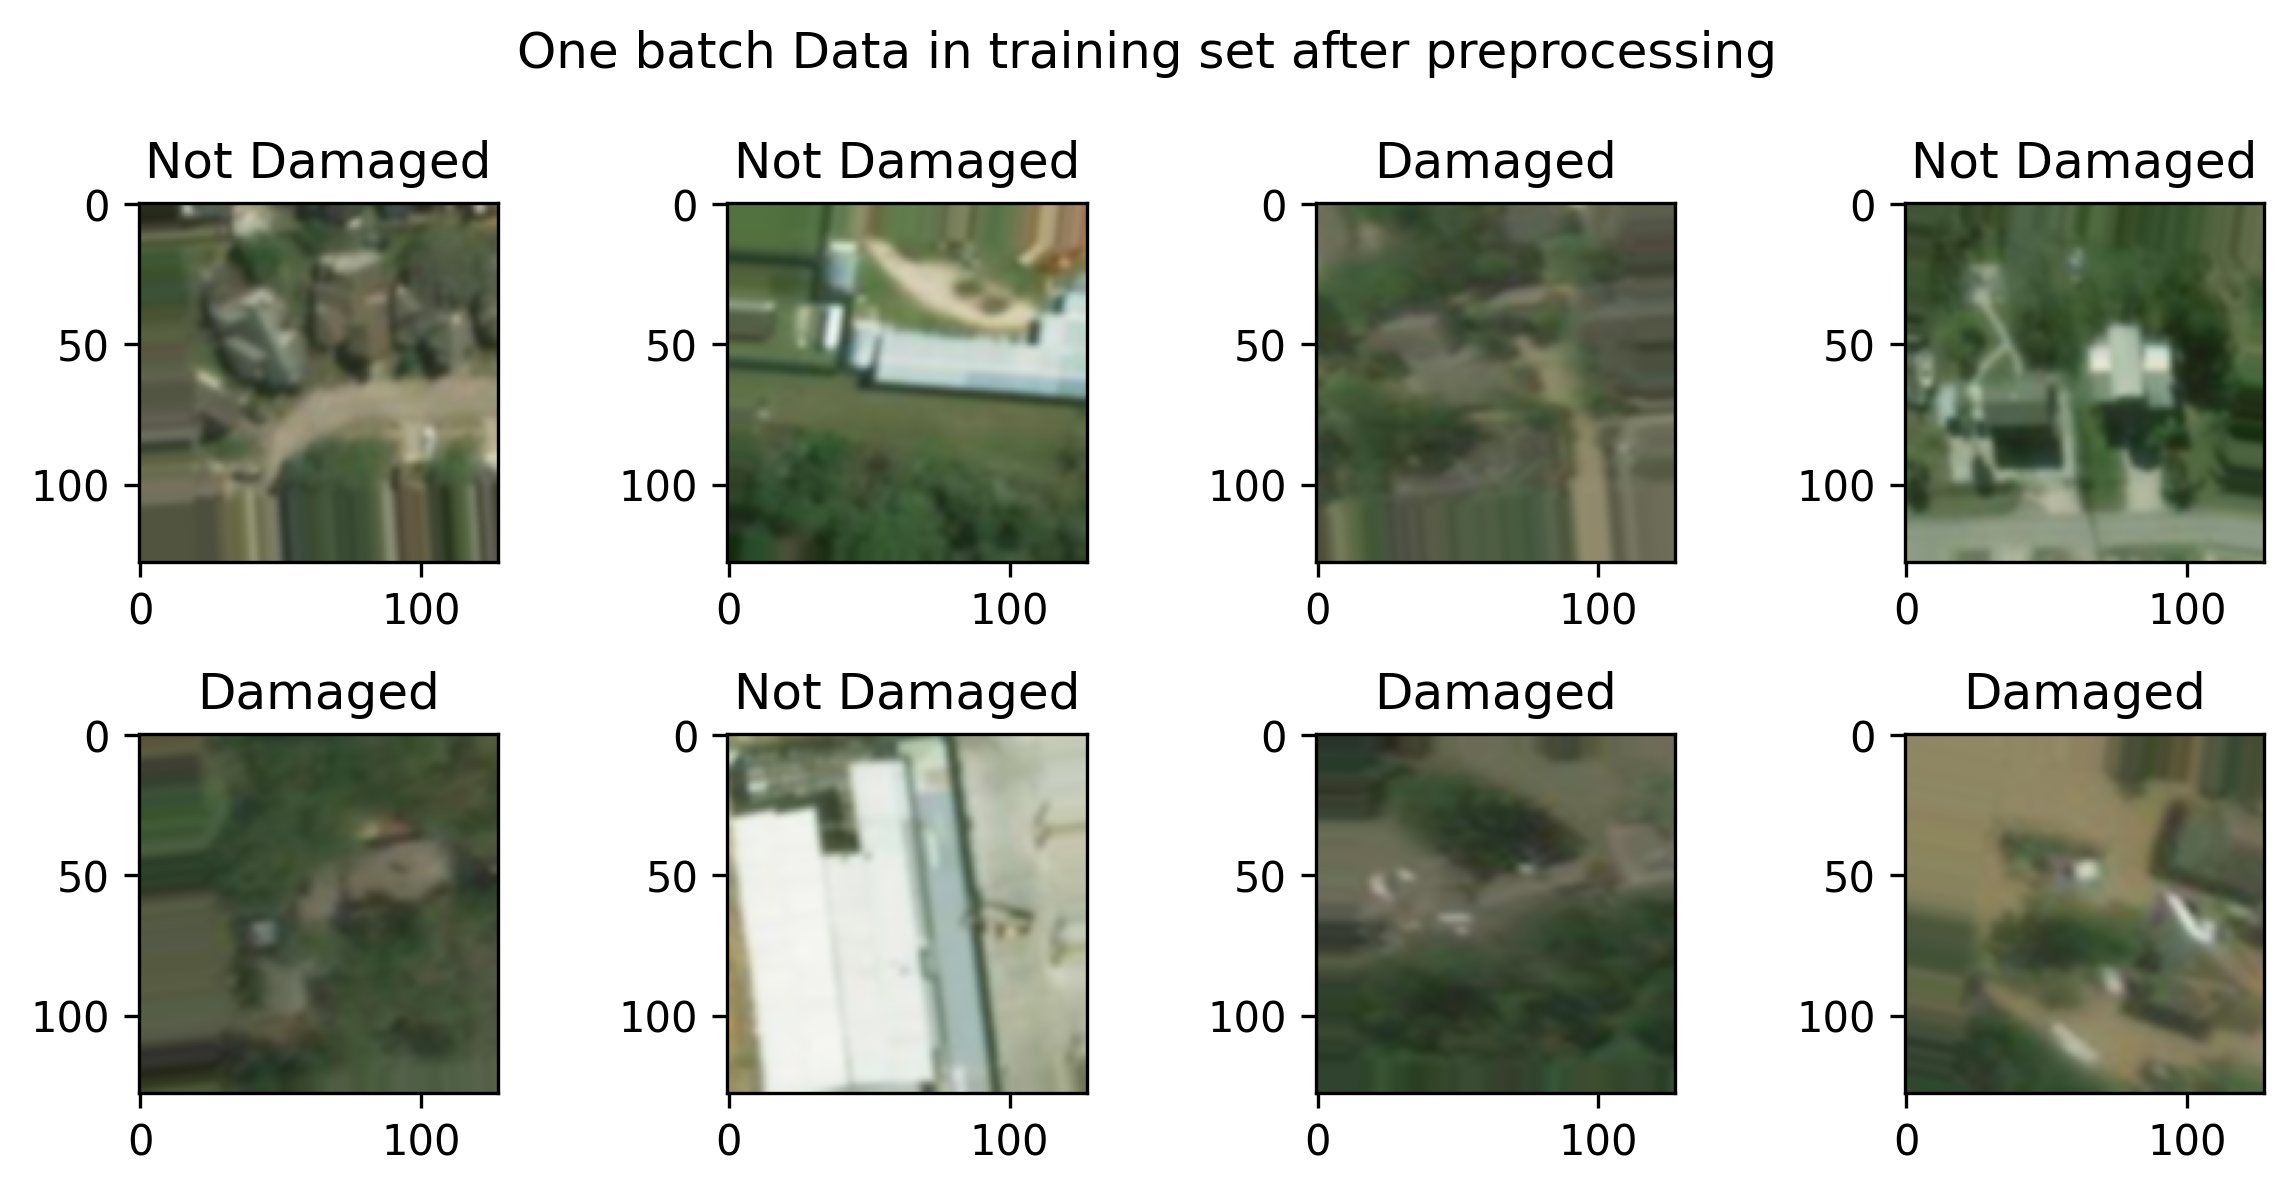

In [9]:
label_dicts={0:'Damaged',1:'Not Damaged'}
x_batch, y_batch = train_data.next()
plt.figure(figsize=(8,4),dpi=300)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])
    plt.title('{}'.format(label_dicts[y_batch[i]]))
plt.suptitle('One batch Data in training set after preprocessing')
plt.tight_layout()
plt.show()

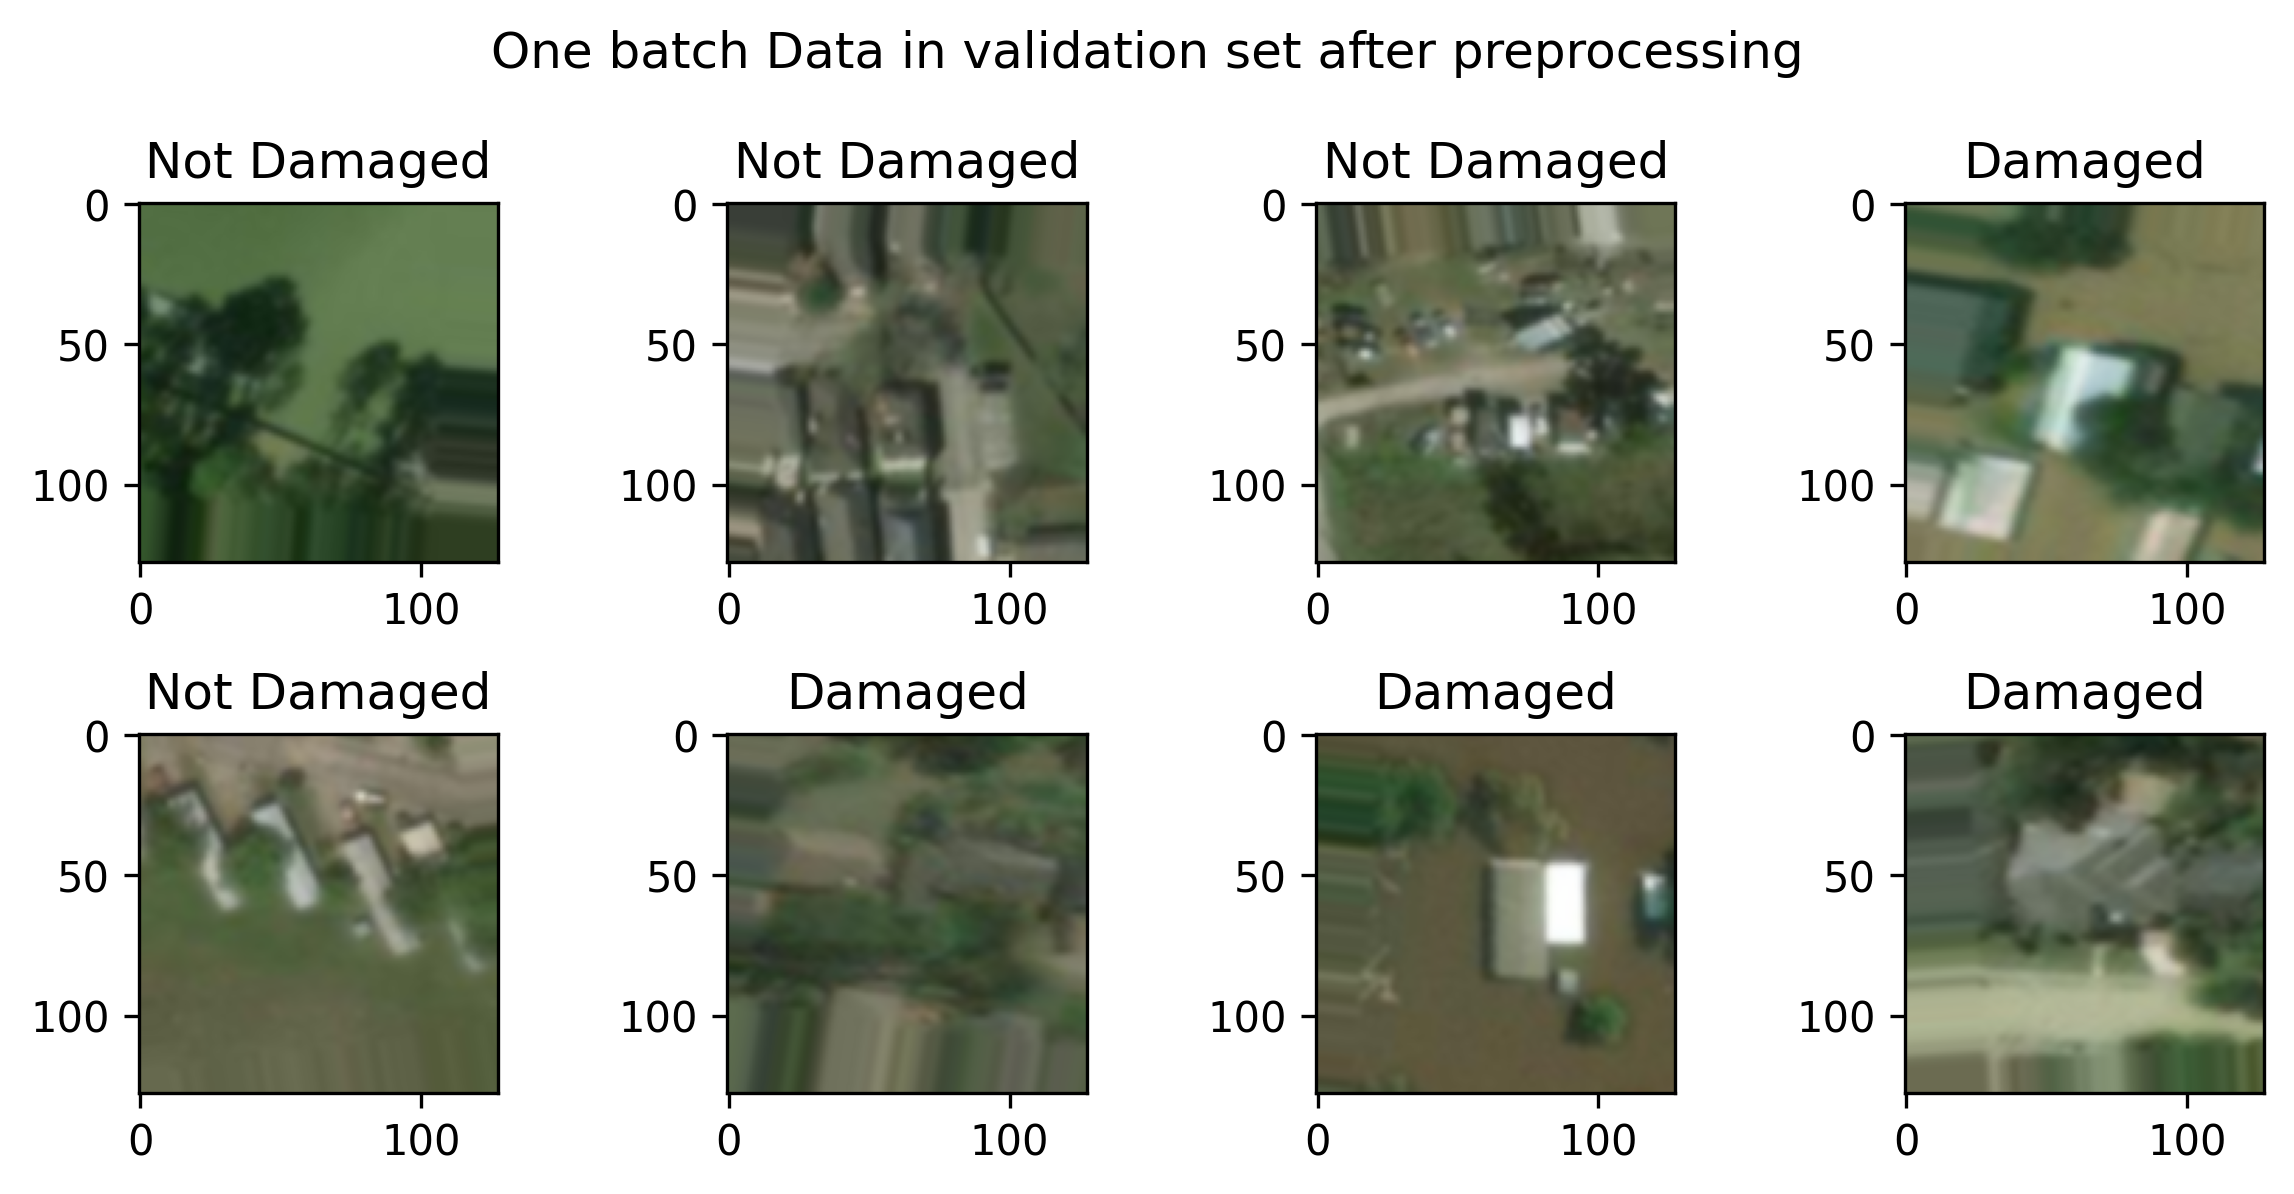

In [10]:
x_batch, y_batch = vali_data.next()
plt.figure(figsize=(8,4),dpi=300)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])
    plt.title('{}'.format(label_dicts[y_batch[i]]))
plt.suptitle('One batch Data in validation set after preprocessing')
plt.tight_layout()
plt.show()

## VGG19 network building and training

The VGG19 we implements here is described below.
Since the input image is about (128$\times$128$\times$3) size large, smaller than the original VGG19 input size 224, so the FC layers attached after the Convlution layers are aslo reduced.

![VGG19 Structure](https://gitee.com/tomgoh/img/raw/master/VGG19.jpg)

In order to avoid overfitting, Regularization methods including L2 Norm and Dropout are deployed.

Here we use a `add_block` function to build a single block of VGG19.
By assigning the number of filter, the number of layers, and ect., we are able to construct VGG19 block by block.

In [11]:
def add_block(model,num_filter,layer_counts,kernel_size=(3,3),pooling=None,pool_size=None,strides=None):
    for i in range(layer_counts):
        model.add(Conv2D(num_filter,kernel_size,activation="relu",padding="same",kernel_regularizer=tf.keras.regularizers.l2(0.01),bias_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(BatchNormalization())
    if pooling:
        model.add(MaxPooling2D(pool_size,strides))

Based on `add_block` function above, we all it 5 times to build the concolutional part of VGG19.

Also, fully connected layers are attcahed behind them. The final output is one neuron with sigmoid activation function, which denotes the probability of the not damage of houses.

In [12]:
def VGG19_Model(filter_of_first_layer=64):
    model = Sequential()
    model.add(Input(shape=(128,128,3)))
    add_block(model,filter_of_first_layer,layer_counts=2,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*2,layer_counts=2,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*4,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*8,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    add_block(model,filter_of_first_layer*8,layer_counts=4,pooling=True,pool_size=(2,2),strides=(2,2))
    model.add(Flatten())
    model.add(Dense(2048,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(2048,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(512,activation="relu"))
    model.add(Dense(1,activation="sigmoid"))
    return model

In [13]:
VGG_Model = VGG19_Model()

Compile the model above, using `BinaryCrossentropy` loss since only two types of results would be predicted. Also SGD optimizer are deployed.

After compiling, train and evaluate the model with train_data data generator and validation_data data generator.

The training and testing result would be displayed with comparison with ResNet18 model's result.

In [14]:
VGG_Model.compile(optimizer='sgd',loss=tf.keras.losses.BinaryCrossentropy(),metrics =['accuracy'])
VGG_Model.summary()
EarlyStop=tf.keras.callbacks.EarlyStopping(patience=10)
vgg_history=VGG_Model.fit_generator(train_data,validation_data=vali_data,epochs=50,shuffle=True,callbacks=[EarlyStop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       5

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1250/1250 [==============================] - 130s 97ms/step - loss: 46.8139 - accuracy: 0.7616 - val_loss: 32.0331 - val_accuracy: 0.8355
Epoch 2/50
1250/1250 [==============================] - 81s 64ms/step - loss: 28.4397 - accuracy: 0.8732 - val_loss: 19.5144 - val_accuracy: 0.8910
Epoch 3/50
1250/1250 [==============================] - 80s 64ms/step - loss: 17.3886 - accuracy: 0.8855 - val_loss: 12.4780 - val_accuracy: 0.5815
Epoch 4/50
1250/1250 [==============================] - 80s 64ms/step - loss: 10.6878 - accuracy: 0.8945 - val_loss: 7.6060 - val_accuracy: 0.7930
Epoch 5/50
1250/1250 [==============================] - 80s 64ms/step - loss: 6.6275 - accuracy: 0.8993 - val_loss: 4.6690 - val_accuracy: 0.8905
Epoch 6/50
1250/1250 [==============================] - 81s 65ms/step - loss: 4.1628 - accuracy: 0.9030 - val_loss: 4.2539 - val_accuracy: 0.5050
Epoch 7/50
1250/1250 [==============================] - 80s 64ms/step - loss: 2.6621 - accuracy: 0.8994 - val_loss: 1.9605 - va

In [15]:
vgg_test_result=VGG_Model.evaluate(test_data)
vgg_another_test_result=VGG_Model.evaluate(another_test_data)

1125/1125 [==============================] - 58s 52ms/step - loss: 0.8372 - accuracy: 0.5833


## ResNet18 network building and training

The ResNet18 we implement here is described below.
Since the input image is about (128$\times$128$\times$3) size large,we change the input size of the model. Also, the final dense layer is changed as well due to only one category is needed to predicted.


![ResNet18 Structure](https://gitee.com/tomgoh/img/raw/master/ResNet.png)


Here we extend the Tensorflow Layer to define our own Residual layer.

Shorcut connection is implemented with `add` function. The `downsample` is kept to reconcile the shape between the former output and the latter input. More in next cell.

In [16]:
class Residual_Block(tf.keras.layers.Layer):
    
    def __init__(self,output_channel,strides=1,downsample=None,**kwargs):
        super(Residual_Block,self).__init__(**kwargs)
        self.conv1=tf.keras.layers.Conv2D(output_channel,kernel_size=(3,3),strides=strides,padding='same',use_bias=False)
        self.conv2=tf.keras.layers.Conv2D(output_channel,kernel_size=(3,3),strides=1,padding='same',use_bias=False)
        self.bn1=tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)
        self.bn2=tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)
        self.downsample=downsample
        self.relu=tf.keras.layers.ReLU()
        self.add=tf.keras.layers.Add()
        
    def call(self,inputs,training=False):
        identity=inputs
        if self.downsample is not None:
            identity=self.downsample(inputs)

        x=self.conv1(inputs)
        x=self.bn1(x,training=training)
        x=self.relu(x)
        
        x=self.conv2(x)
        x=self.bn2(x,training=training)
        x=self.add([identity, x])
        x=self.relu(x)
        
        return x
    


All we need to do is to assemble the Residual Layer defined above to construct the whole network.

One thing needs to pay attention is that between two residual blocks, the output shape of the former one is always incompatible with the output shape of the latter layer, so downsample is needed to reduce the dimention of the output from the former layer. And in order to do that, we add an `if` judgement to find whether the output shape is compatiable with the input shape.

In [17]:
def Build_Layer(input_channel,channel,block_num,strides=1):
    downsample=None
    if strides !=1 or input_channel!=channel:
        downsample=tf.keras.Sequential([
            tf.keras.layers.Conv2D(channel,kernel_size=(1,1),strides=strides,use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(0.01),bias_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)
        ])
        
    layers_list=[]
    layers_list.append(Residual_Block(channel,downsample=downsample,strides=strides))
    for i in range(1,block_num):
        layers_list.append(Residual_Block(channel))
    return tf.keras.Sequential(layers_list)

def build_ResNet18():
    inputs=tf.keras.layers.Input(shape=(128,128,3),dtype='float32')
    x=tf.keras.layers.Conv2D(filters=64,kernel_size=(7,7),strides=2,padding='same',use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(0.01),bias_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x=tf.keras.layers.BatchNormalization(momentum=0.9,epsilon=1e-5)(x)
    x=tf.keras.layers.ReLU()(x)
    x=tf.keras.layers.MaxPooling2D()(x)
    
    x=Build_Layer(input_channel=128,channel=64,block_num=2)(x)
    x=Build_Layer(input_channel=128,channel=128,block_num=2,strides=2)(x)
    x=Build_Layer(input_channel=128,channel=256,block_num=2,strides=2)(x)
    x=Build_Layer(input_channel=128,channel=512,block_num=2,strides=2)(x)
    
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs=tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
    
    ResNet18=tf.keras.Model(inputs=inputs,outputs=outputs)
    return ResNet18

Build and train.

Using same strategy as training VGG19, including same optimizer, same data generator, same loss and same epoches. 

Results would be displayed and analized after training finished.

In [18]:
ResNet_Model=build_ResNet18()

In [19]:
ResNet_Model.compile(optimizer='sgd',loss=tf.keras.losses.BinaryCrossentropy(),metrics =['accuracy'])
ResNet_Model.summary()
EarlyStop=tf.keras.callbacks.EarlyStopping(patience=10)
resnet_history=ResNet_Model.fit_generator(train_data,validation_data=vali_data,epochs=50,shuffle=True,callbacks=[EarlyStop])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        9408      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 64)        152832    
_________________________________________________________________
sequential_4 (Sequential)    (None, 16, 16, 128)       526848

In [20]:
resnet_test_result=ResNet_Model.evaluate(test_data)
resnet_another_test_result=ResNet_Model.evaluate(another_test_data)

1125/1125 [==============================] - 19s 17ms/step - loss: 0.1710 - accuracy: 0.9486


**Summary of training**:

In this training part, we could clearly see the differences between VGG and ResNet.

First, VGG tends to overfit the training data with only about twenty epochs, while on the contrary ResNet finish all 50 epochs and continues to lower down the validation loss.

Second, VGG gets more viberations of loss and accuracy during the training, and also ResNet has the same situation. We have tried to changed the loss function and learning rate, but this situation continues to appear. More work should be done to investigate in the future.

Last, ResNet has a better gnerlization ability than VGG. Although both models got more than 90% accuracy over the validation sets, but VGG could not work well on the two testsets, while ResNet does it much better.

## Result Display and Comparison

We first display the Loss and Accuracy of those two models on training sets and valisation sets.

Then we use Occlusion Map to see which network has a better Fearure Extraction ability.

At last, we also deploy GradCam Map to see the Feature Extraction ability of those two models, to see whether ResNet could have a better performance over VGG with similar conditions and convolutional structures.

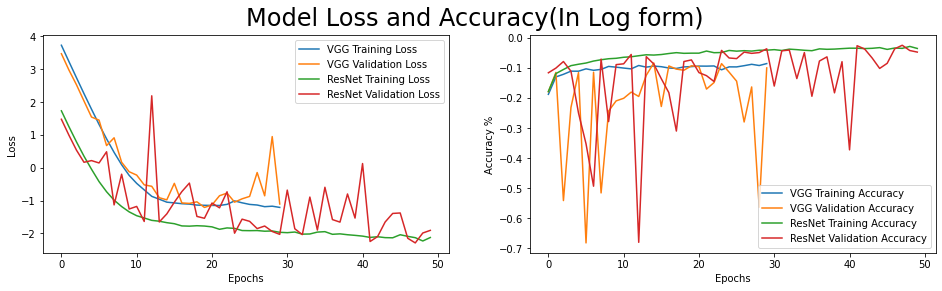

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(np.log(vgg_history.history['loss']), label='VGG Training Loss')
ax[0].plot(np.log(vgg_history.history['val_loss']), label='VGG Validation Loss')
ax[1].plot(np.log(vgg_history.history['accuracy']), label='VGG Training Accuracy')
ax[1].plot(np.log(vgg_history.history['val_accuracy']),label='VGG Validation Accuracy')

ax[0].plot(np.log(resnet_history.history['loss']), label='ResNet Training Loss')
ax[0].plot(np.log(resnet_history.history['val_loss']), label='ResNet Validation Loss')
ax[1].plot(np.log(resnet_history.history['accuracy']), label='ResNet Training Accuracy')
ax[1].plot(np.log(resnet_history.history['val_accuracy']),label='ResNet Validation Accuracy')

ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('Model Loss and Accuracy(In Log form)', fontsize=24)
plt.show()

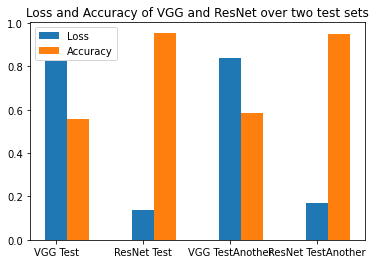

In [22]:
p=np.arange(0,8,2)
width=0.5
move=width/2
plt.bar(p-move,[vgg_test_result[0],resnet_test_result[0],vgg_another_test_result[0],resnet_another_test_result[0]],width=width,label='Loss',tick_label=['VGG Test','ResNet Test','VGG TestAnother','ResNet TestAnother'])
plt.bar(p+move,[vgg_test_result[1],resnet_test_result[1],vgg_another_test_result[1],resnet_another_test_result[1]],width=width,label='Accuracy')
plt.legend()
plt.title('Loss and Accuracy of VGG and ResNet over two test sets')
plt.show()

From results above we could clearly see the difference of loss and accuracy of different models.

On both validation sets and two other test sets, the ResNet had a better performance while VGG almost could not handle the "test another" dataset.

The Occlusion map below may help explain why.

Here we define a function that help to generate a group of occlusion pictures of an input of an image.

In [ ]:
def generate_occlusion(image_array,occlusion_size):
    occlusion=np.full((occlusion_size,occlusion_size,3),0)
    maps=[]
    for i in range(0,128,occlusion_size):
        for j in range(0,128,occlusion_size):
            temp=image_array.copy()
            temp[i:i+occlusion_size,j:j+occlusion_size,:]= occlusion
            maps.append(temp)
    return maps

With the help of occlusion map of the function above, we are able to see which part of the input image could stimulate the model the most.

Here we ues the function above to get $\frac{Image Size}{Occlusion Size}$ occlusion pitcures, and put them into the trained model one by one.

What we measure the ability of feature extraction of a model is to generat a mask, where the largest output of the model is 1, and other outputs $OutputValue_i$ would be displayed as a ratio $ \frac{OutputValue_i}{Outputvalue_{max}}$, and plot to the mask. When the ratio is larger than a defined threshold, the corresponding position would be 1, otherwise 0. And we use the generated mask to cover the original image, parts remain visiuable would be most decisive within the input image.

Also, when making comparision between those two models, how they do feature extractions could be visualized by this method, too. We could see which model could clearly distinguish which part of an input image could be the most decisive part. 

In [ ]:
def occlusion_final(image_path,Model,ratio):
    image=Image.open(image_path)
    image_array=np.array(image)/225.
    size=16
    maps=generate_occlusion(image_array,size)
    occlusion_size=int(128/size)
    result_map=np.zeros((128,128))
    index=0
    
    for image in maps:
        result=Model.predict(image[np.newaxis,:,:,:])

        x=int(index/occlusion_size)
        y=int(index%occlusion_size)
        result_map[x*size:((x+1)*size+1),y*size:((y+1)*size+1)]=result[0][0]
        index+=1

    result_map1=result_map/result_map.max()
    mask = result_map1 > ratio
    mask = mask.astype(int)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(128,128))
    mask = mask.astype('uint8')
    final = cv2.bitwise_and(image,image,mask = mask)
    final = cv2.cvtColor(final,cv2.COLOR_BGR2RGB)
    return final

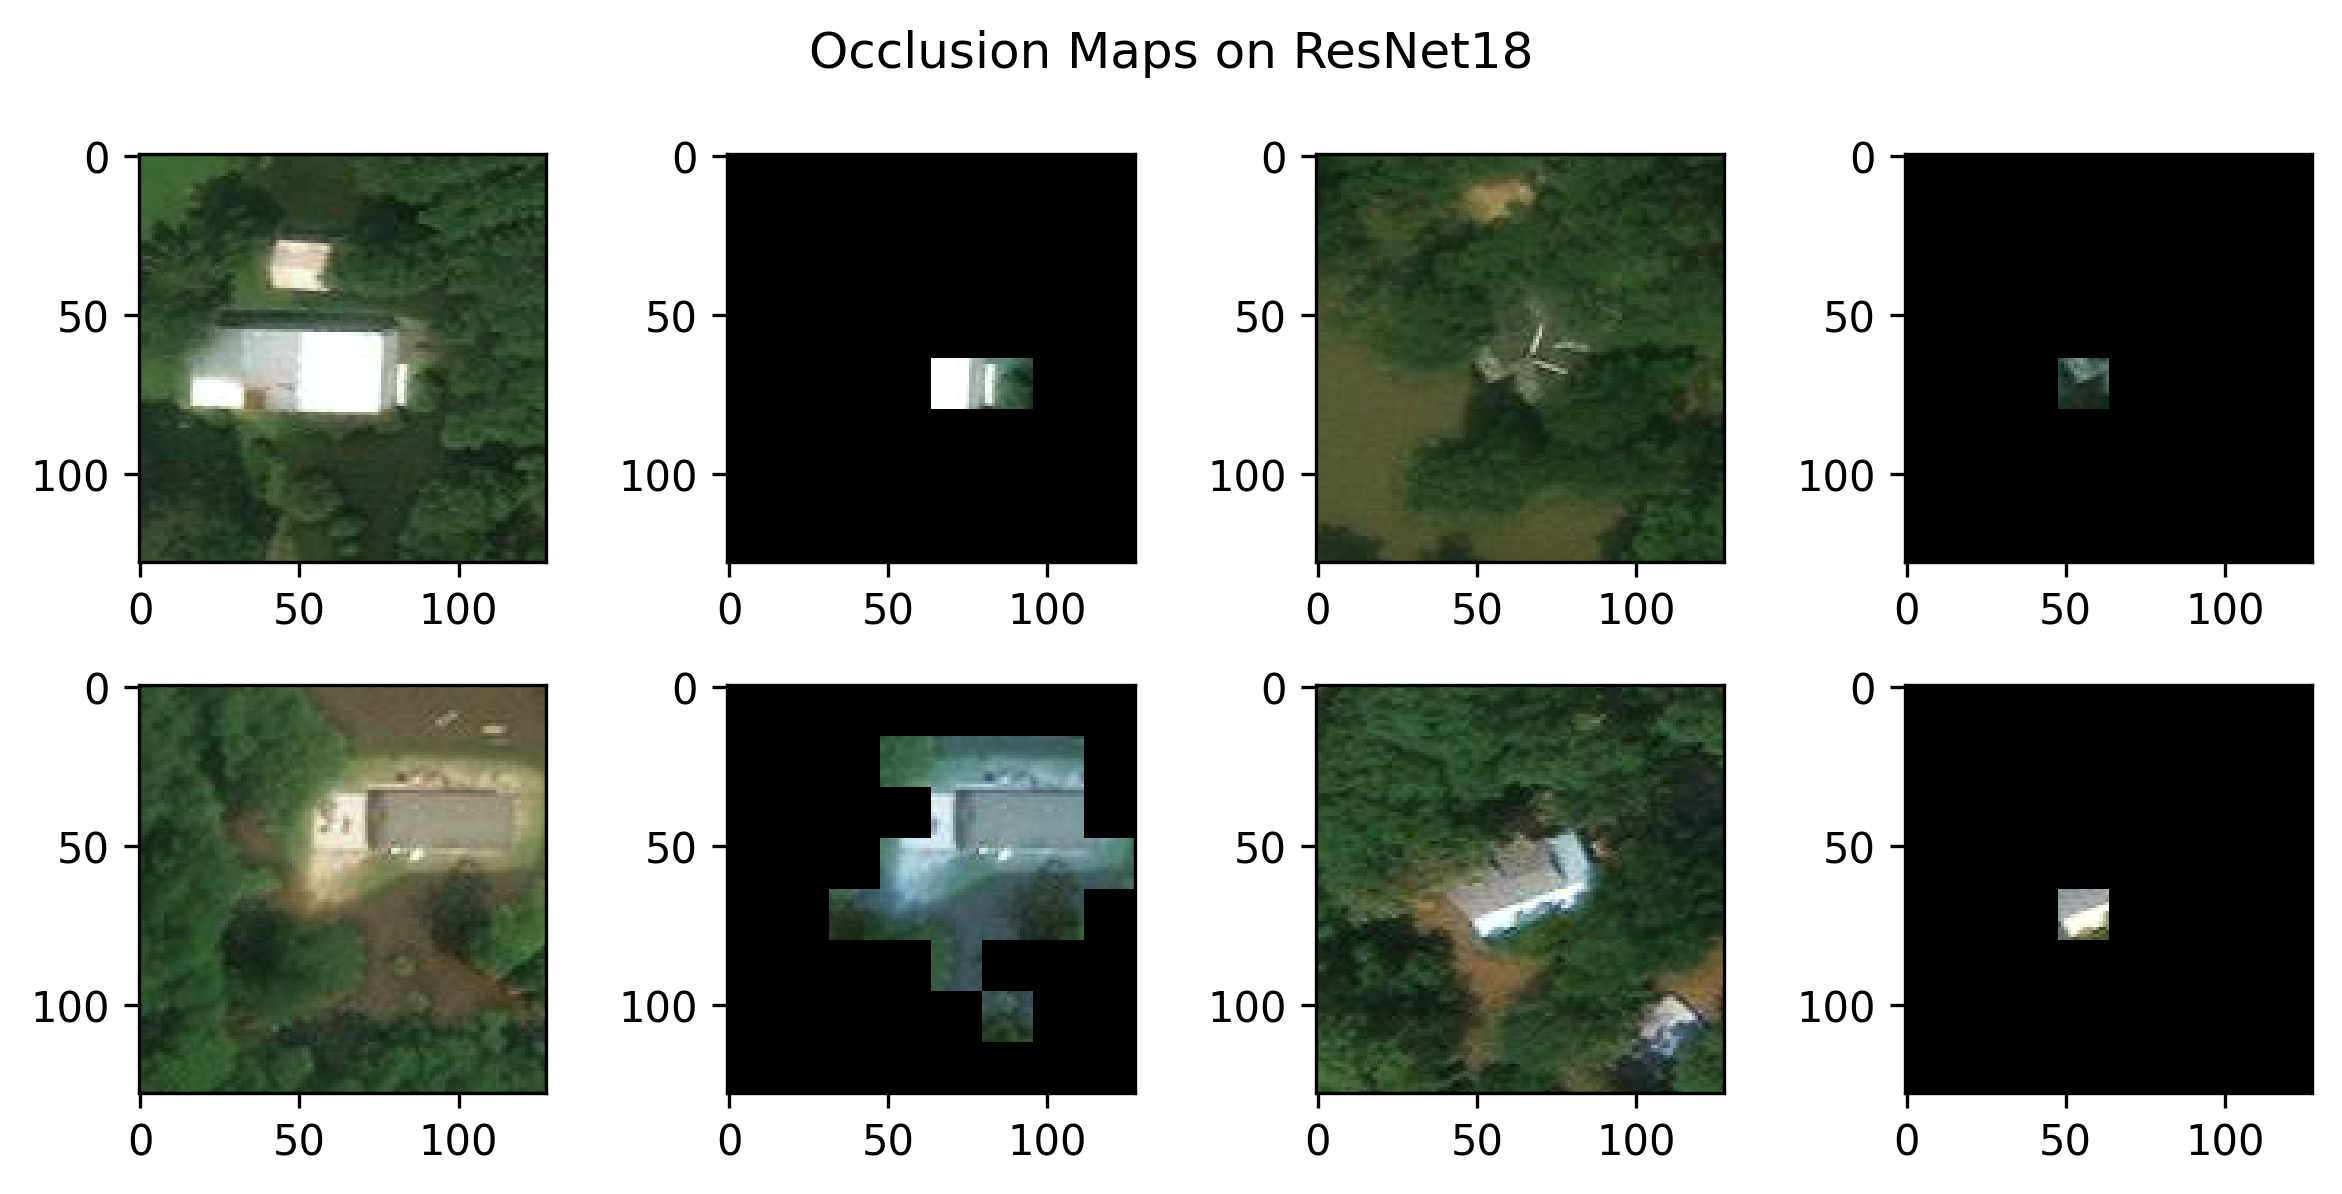

In [28]:

image_list=[dataset_path+'train_another/damage/-93.573763_30.693981.jpeg',dataset_path+'train_another/damage/-93.60299300000001_30.793817999999998.jpeg',
           dataset_path+'test/damage/-93.658785_30.206929.jpeg',dataset_path+'test/damage/-93.590598_30.694956.jpeg']

# damage = glob.glob(dataset_path+'train_another/damage/*.jpeg')
# for i in range(4):
#     image_list.append(damage[random.randint(0,len(damage))])

plt.figure(figsize=(8,4),dpi=300)
for i in range(8):
    if i%2 !=0:
        plt.subplot(2,4,i+1)
        plt.imshow(occlusion_final(image_list[int((i-1)/2)],ResNet_Model,ratio=0.8))
    else:
        plt.subplot(2,4,i+1)
        plt.imshow(Image.open(image_list[int(i/2)]))

plt.suptitle('Occlusion Maps on ResNet18')
plt.tight_layout()
plt.show()

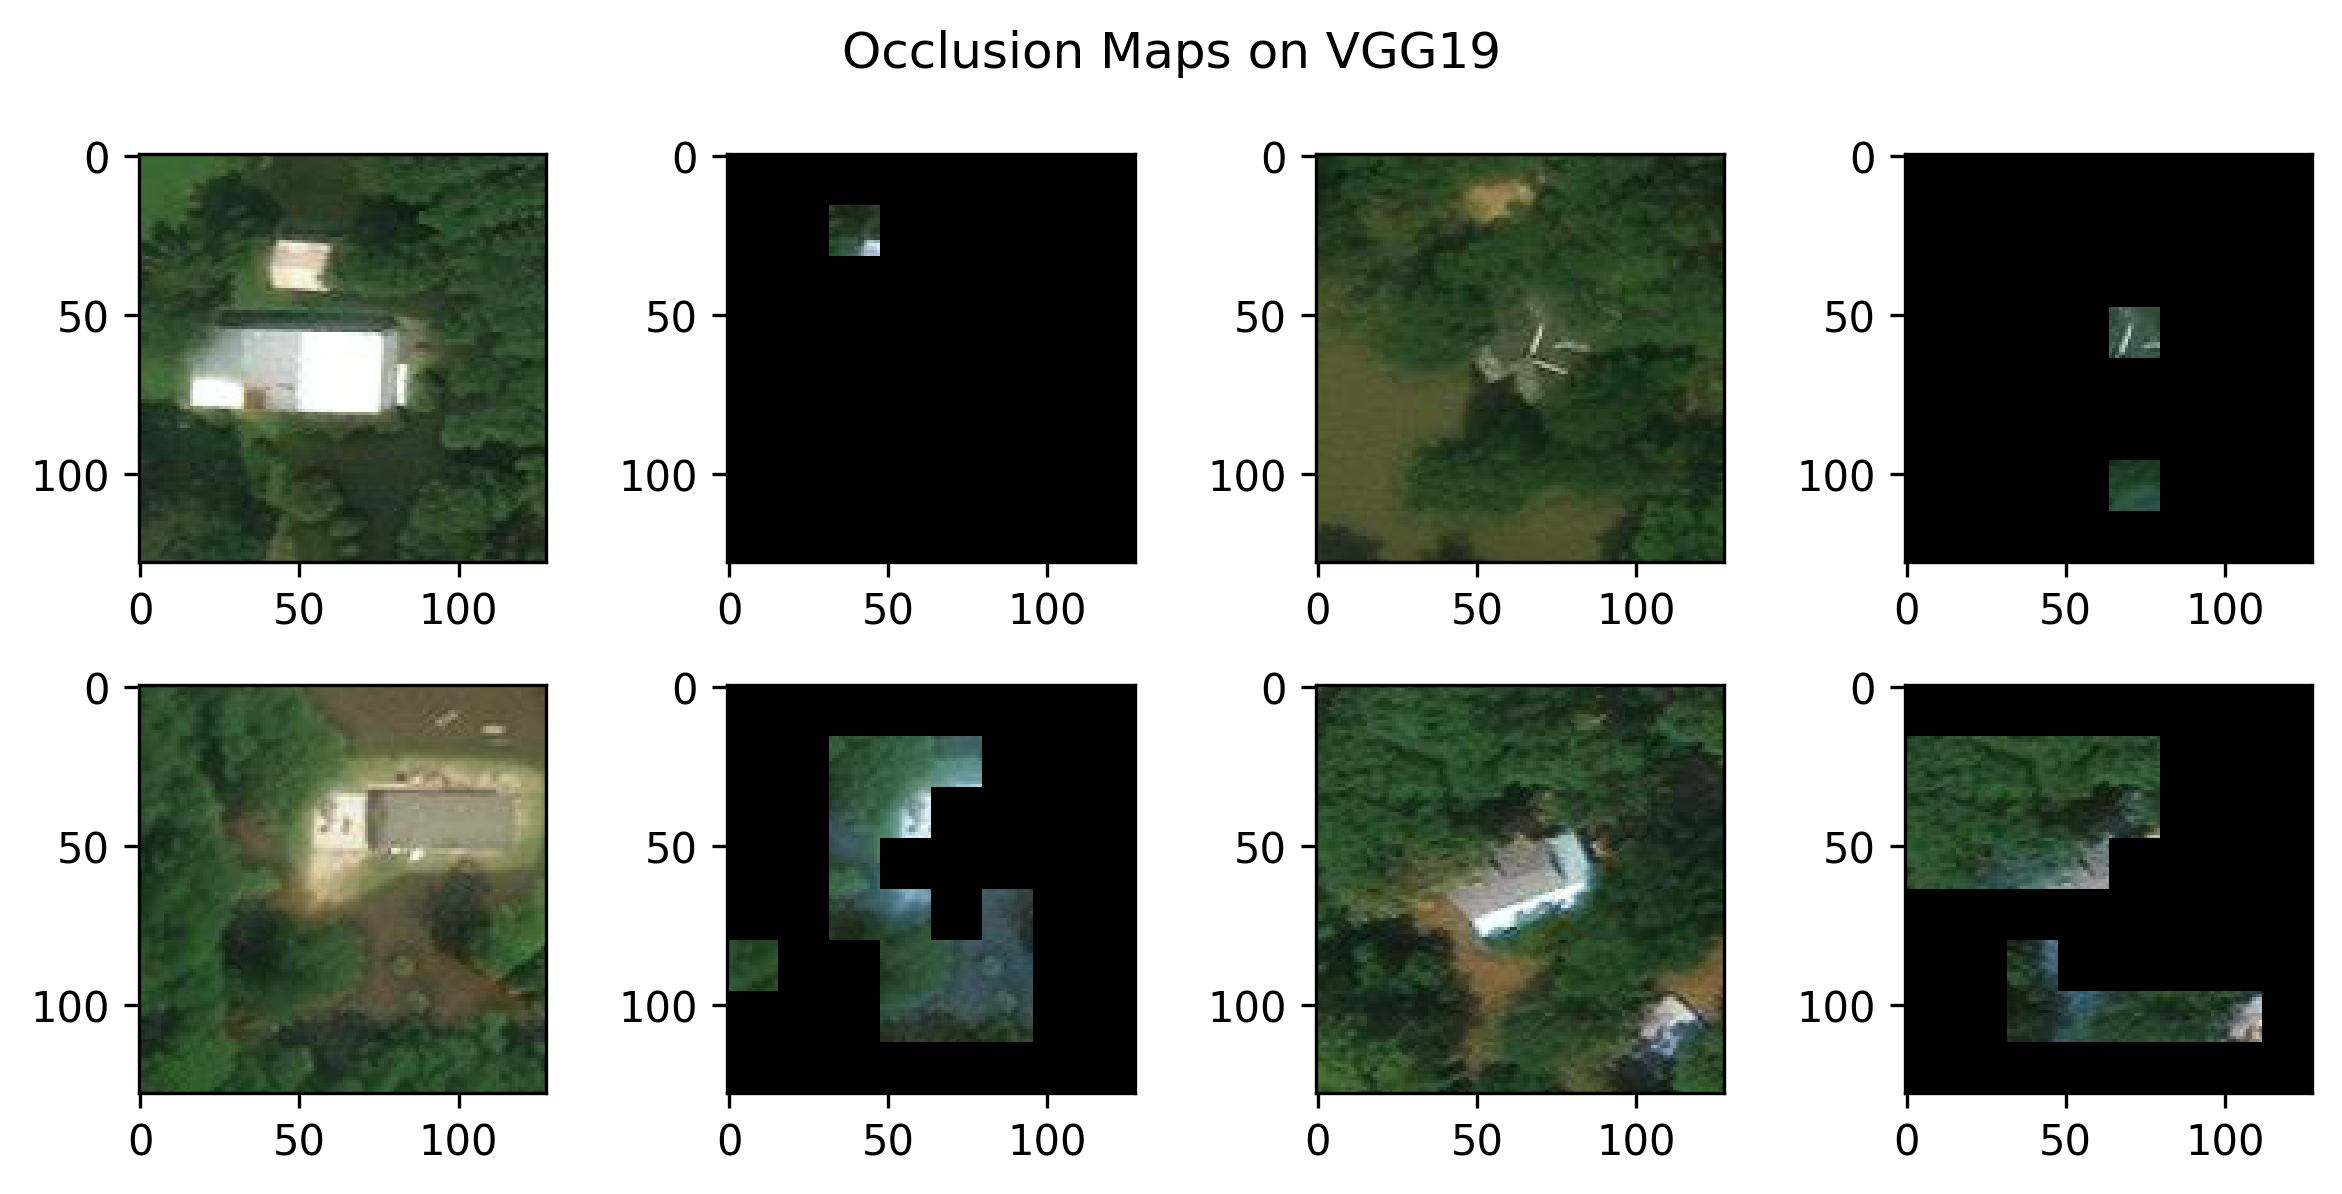

In [27]:
plt.figure(figsize=(8,4),dpi=300)
for i in range(8):
    if i%2 !=0:
        plt.subplot(2,4,i+1)
        plt.imshow(occlusion_final(image_list[int((i-1)/2)],VGG_Model,ratio=0.8))
    else:
        plt.subplot(2,4,i+1)
        plt.imshow(Image.open(image_list[int(i/2)]))

plt.suptitle('Occlusion Maps on VGG19')
plt.tight_layout()
plt.show()

**Discoveries and Interpretation**:

From the charts above we could clearly see that charts from ResNet have more pieces of images whose visible areas are areas where houses located, while almost no clear occlusion map could be drawn on the output of VGG network even we increase the comparison ratio to 0.8 which means only parts with more impacts would be displayed, and even the visible parts are often trees and water, which is not the main object house in the images. VGG relies more parts within an image to do decision while ResNet could grasp the most essential part.

The interpretation is that with the help of shortcut connection, ResNet could grasp which part of image would be most important. Since the number of convolution layers are almost the same, the only thing that could lead to better performance of ResNet over VGG is the shortcut connection. Without the shortcut connection, VGG network failed to grasp the main features and the most decisive part of houses, so the accuracy is low and also the generlization performance was not satisfied.

## Conclusion and Feture work

From coded and charts above, we have deeply realize the powerful impact of Residual block and Shortcut Connection. 

We have acheievd 95.55% Accuracy on test data and 94.86% Accuracy over another test data with trained ResNet18 model. And with Occlusion map we could clearly know what is going on in the network and which model could have a better ability of feature extraction.

Also, few problems were found and summarized during the project.

First, the accuracy viberation and bouncing during the training process is weird and we do not what had caused such a problem. We have changed many loss functions and preprocessing strategies, but such a scenario happened again and again. We need more experiments to know what exactly caused this.

Second, many more complex architectures we have not leant. Excellent models, such as Inception, DenseNet, UNet, and so on, have not been implemented and learnt by us. Future study of thoes networks and ideas why scholars designed such architectures should be done.

Third, more ways of rating a model and modift it for better performace would always be our goal.